##**Data Loading**

In [38]:
!conda info


     active environment : cl
    active env location : /home/vision_tcs/anaconda3/envs/cl
            shell level : 1
       user config file : /home/vision_tcs/.condarc
 populated config files : /home/vision_tcs/.condarc
          conda version : 23.5.0
    conda-build version : 3.24.0
         python version : 3.10.9.final.0
       virtual packages : __archspec=1=x86_64
                          __cuda=12.2=0
                          __glibc=2.31=0
                          __linux=5.14.0=0
                          __unix=0=0
       base environment : /home/vision_tcs/anaconda3  (writable)
      conda av data dir : /home/vision_tcs/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /hom

In [39]:
import numpy as np
import torch
import torch.nn as nn

In [40]:
import pickle
def feature_loader(path_feature,path_label):
  flatten_features = []
  with open(path_feature, 'rb') as filehandle:
    # read the data as binary data stream
    features = pickle.load(filehandle)
  with open(path_label, 'rb') as filehandle:
    # read the data as binary data stream
    paths = pickle.load(filehandle)
  for i in features:
    flatten_features.append(np.array(i).astype(np.float32))
  return np.array(flatten_features),paths

In [41]:
train_features,train_paths = feature_loader('CORe50_resnet34_train_features.data','CORe50_resnet34_train_labels.data')
train_features.shape,len(train_paths)

((119894, 512), 119894)

In [42]:
test_y = []
test_x,test_paths = feature_loader('CORe50_resnet34_test_features.data','CORe50_resnet34_test_labels.data')
for path in test_paths:
  cls_no = (int(path[5:7])-1)//5
  test_y.append(cls_no)
test_y =np.array(test_y)
test_x.shape,test_y.shape

((44972, 512), (44972,))

In [43]:
d = {}
for path in train_paths:
  s = int(path[2:4])
  if s not in d.keys():
    d[s]=1
  else:
    d[s] += 1

d

{11: 14991,
 2: 14986,
 9: 14994,
 1: 14989,
 8: 14984,
 5: 14966,
 6: 14989,
 4: 14995}

In [44]:
d = {}
for path in test_paths:
  s = int(path[2:4])
  if s not in d.keys():
    d[s]=1
  else:
    d[s] += 1

d

{3: 14992, 10: 14986, 7: 14994}

In [45]:
class Classifier(nn.Module):

    def __init__(self,num_class):
        super(Classifier,self).__init__()

        self.linear1 = nn.Linear(512,num_class)

    def forward(self,x):
        x = self.linear1(x)
        return x


In [46]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        label = self.labels[index]

        if self.transform:
            sample = self.transform(sample)

        return sample, label


In [47]:
np.unique(test_y,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([4499, 4496, 4500, 4495, 4499, 4498, 4496, 4495, 4499, 4495]))

##**xyz**

In [48]:
import numpy as np

class DataProcessing:

  def __init__(self):
    self.selected_obj = []

  def rand_data_extractor(self):
    selected_obj_num = []

    for i in self.selected_obj:
      x,y = int(i[:2]),int(i[3:])
      if x < 3:
        z = (x-1)*50 + y

      elif x>2 and x<7:
        z = (x-2)*50 + y
      elif x!=11:
        z = (x-3)*50 + y
      else:
        z = (x-4)*50 + y
      selected_obj_num.append(z)

    rand_selected = []
    while len(rand_selected) !=5:
      x = np.random.randint(1,401,size = 1)
      if x not in selected_obj_num:
        rand_selected.append(x)


    for i in rand_selected[:5]:
      a,b = divmod(int(i),50)

      if b == 0:
        a,b = a-1,50

      if a < 2:
        s = '0'+str(a+1)
      elif a>1 and a< 5:
        s = '0'+str(a+2)
      elif a!=7:
        s = '0'+str(a+3)
      else:
        s = 11

      b = '0'+str(b) if b <10 else str(b)


      rand_selected.append(str(s)+'_'+ b)

    return rand_selected[5:]

  def data_selector(self,features,paths,season=1,object=1):
    data = []
    for i,path in enumerate(paths):
      s_n = int(path[-12:-14:-1][::-1]) # Session Number
      o_n = int(path[-9:-11:-1][::-1])  # Object Number

      if season == s_n and object == o_n:
        data.append(features[i])
    class_no = (object-1)//5
    return np.array(data),class_no*np.ones(len(data))

In [49]:
x,y = DataProcessing().data_selector(train_features,train_paths,season=4,object=2)
x.shape,y.shape

((300, 512), (300,))

In [50]:
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=12,min_samples=10)
dbscan.fit(x)
np.unique(dbscan.labels_,return_counts=True)


(array([-1,  0,  1,  2,  3,  4]), array([ 25,  36,  58, 110,  22,  49]))

**Analysis**

In [51]:
from numpy.linalg import norm

def distance(a,b):
    return norm(a-b)

def cosine_similarity(A,B):
    return A.dot(B)/(norm(A)*norm(B))


In [52]:
'''
Active sample selection criterion : We will select those  samples which has minimum 'cosine similarity'.
    After that we may take separate or coinciding variational autoencoder depends on cosine similarity and distance.
    If it is less than particular threshold than we will not take any extra variational autoencoder.
'''

"\nActive sample selection criterion : We will select those  samples which has minimum 'cosine similarity'.\n    After that we may take separate or coinciding variational autoencoder depends on cosine similarity and distance.\n    If it is less than particular threshold than we will not take any extra variational autoencoder.\n"

# **VAE Learning**

In [53]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, input_size, latent_size):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = nn.Linear(input_size, input_size//4)
        self.relu = nn.ReLU()
        self.fc_mu = nn.Linear(input_size//4, latent_size)
        self.fc_logvar = nn.Linear(input_size//4, latent_size)

        # Decoder
        self.fc2 = nn.Linear(latent_size, input_size//4)
        self.fc3 = nn.Linear(input_size//4, input_size)

    def encode(self, x):
        h = self.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.relu(self.fc2(z))
        recon_x = self.relu(self.fc3(h))
        return recon_x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Loss function for VAE
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.MSELoss(reduction='mean')(recon_x, x)

    # Kullback-Leibler divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return 0.92*BCE + 0.08*KLD,BCE,KLD


# Initialize the VAE
input_size = 512
latent_size = 32
learning_rate = 5e-3

vae = VAE(input_size, latent_size)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)


In [54]:
class VAE_CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]

        if self.transform:
            sample = self.transform(sample)

        return sample

In [55]:
def vae_training(x,input_size = 512,latent_size = 32,batch_size = 8,num_epochs = 15,learning_rate = 5e-3,device = 'cpu'):
    vae = VAE(input_size, latent_size)
    vae.to(device)
    optimizer = optim.Adam(vae.parameters(), lr=learning_rate)
    custom_dataset = VAE_CustomDataset(x)
    train_loader = torch.utils.data.DataLoader(custom_dataset, batch_size = batch_size,shuffle = True)
    # Training loop
    for epoch in range(num_epochs):
        recons_loss = 0.0
        kld_loss = 0.0
        total_loss = 0.0
        for batch_idx, data in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            total_loss += loss[0]
            recons_loss += loss[1]
            kld_loss += loss[2]
            loss[0].backward()
            optimizer.step()

    print('Epoch [{}/{}], Loss: {}'.format(epoch + 1, num_epochs, (total_loss,recons_loss,kld_loss)))
    return nn.Sequential(vae.fc2,nn.ReLU(),vae.fc3,nn.ReLU())


In [56]:
import torch
class VAE_CAL:
    
    def __init__(self,device = 'cpu'):
        np.random.seed(0)
        torch.manual_seed(0)
        self.vaes = [None]*10
        self.data_means = [None]*10
        self.weights = [None]*10
        self.data_processing = DataProcessing()
        self.device = device
        self.input_size = 512
        self.latent_size = 32

    def update_knowledge_base(self,x,y,similarity_score_thresold = 0.8,
                            batch_size = 8,num_epochs =15,learning_rate = 5e-3): # x is data and y is class no.

        if self.data_means[y] is not None:
            similarity_scores = []
            curr_mean = np.mean(x,axis=0)
            for mean in self.data_means[y]:
                similarity_scores.append(cosine_similarity(curr_mean,mean))

            most_similar_index = similarity_scores.index(max(similarity_scores))
            if similarity_scores[most_similar_index]> similarity_score_thresold:
                with torch.no_grad():
                    x_rehearsal = self.sampling(y,most_similar_index)
                    x = torch.concatenate([torch.Tensor(x).to(self.device),x_rehearsal],axis=0)
                    self.data_means[y][most_similar_index]= torch.mean(x,axis=0).detach().cpu().numpy()
                
                with torch.enable_grad():
                    self.weights[y][most_similar_index] = x.shape[0]
                    decoder = vae_training(x,input_size = self.input_size,latent_size = self.latent_size,
                                           batch_size = batch_size,learning_rate = learning_rate,device= self.device)
                    self.vaes[y][most_similar_index] = decoder
            else:
                self.data_means[y].append(np.mean(x,axis=0))
                self.weights[y].append(x.shape[0])
                decoder = vae_training(x,input_size = self.input_size,latent_size = self.latent_size,
                            batch_size = batch_size,learning_rate = learning_rate,device= self.device)
                self.vaes[y].append(decoder)

        else:
            self.data_means[y] = [np.mean(x,axis=0)]
            self.weights[y] = [x.shape[0]]
            decoder = vae_training(x,input_size = self.input_size,latent_size = self.latent_size,
                       batch_size = batch_size,learning_rate = learning_rate,device= self.device)
            self.vaes[y] = [decoder]

    def active_sample_selection(self,random_objects,features,paths):
        best_cosine_distance = []
        datas = []

        for obj in random_objects:
            similarities = []
            s,o = int(obj[:2]),int(obj[3:]) # s is season_no, o is object number and c is class
            c = (o-1)//5
            data = self.data_processing.data_selector(features,paths,season = s, object = o)
            data_mean = np.mean(data[0],axis=0)

            for cls_mean in self.data_means:
                if cls_mean is not None:
                    for mean in cls_mean:
                        similarities.append(cosine_similarity(mean,data_mean))

            if len(similarities)==0:
                self.data_processing.selected_obj.append(obj)
                return data

            best_cosine_distance.append(max(similarities))
            datas.append(data)

        index = best_cosine_distance.index(min(best_cosine_distance))
        self.data_processing.selected_obj.append(random_objects[index])
        return torch.Tensor(datas[index][0]),datas[index][1]


    def sampled_data(self):
        data = []
        labels = []
        for i,cls in enumerate(self.vaes):
            if cls is not None:
                for j,decoder in enumerate(cls):
                    data.append(self.sampling(i,j))
                    labels.append(i*np.ones(self.weights[i][j]))
        if len(data) != 0:
            return torch.concatenate(data,axis=0),np.concatenate(labels,axis=0)

    def sampling(self,i,j,num_gen_samples = 1):
        gen_samples = []
        for _ in range(num_gen_samples):
            gen_samples.append(self.vaes[i][j](torch.randn(self.weights[i][j],self.latent_size).to(self.device)))

        distances = []
        for gen_sample in gen_samples:
            distances.append(np.mean(distance(self.data_means[i][j],gen_sample.detach().cpu().numpy())))
        return gen_samples[distances.index(min(distances))]

In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [60]:
test_x,test_y = torch.Tensor(test_x).to(device),torch.Tensor(test_y).to(device)
test_x.is_cuda

True

In [61]:
test = {}
for k in range(5):
  classifier = Classifier(10)
  classifier.to(device)
  model = VAE_CAL()
  model.device = device
  no_test_samples = test_y.shape[0]
  test_accuracies = []
  batch_size = 16
  max_count = 100
  for i in range(0,max_count):
    random_objects = model.data_processing.rand_data_extractor()
    data = model.active_sample_selection(random_objects,train_features,train_paths)
    features = data[0]
    data_y = data[1]
    prev_data = model.sampled_data()
    if prev_data is not None :
      labelled_data = torch.concatenate([prev_data[0].detach().cpu(),features],axis=0)
      labelled_label = np.concatenate([prev_data[1],data_y],axis=0)
    else:
      labelled_data = features
      labelled_label = data_y
    custom_dataset = CustomDataset(labelled_data,labelled_label)
    train_loader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size,shuffle = True)
    print(labelled_data.shape,labelled_label.shape)
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(classifier.parameters(),lr=0.001,momentum = 0.9)
    with torch.enable_grad():
      for epoch in range(1,101):
        correct_predictions = 0
        total_samples = 0
        running_loss = 0.0
        for batch in train_loader:  # Iterate over batches of training data
          inputs, labels = batch
          inputs, labels = inputs.to(device), labels.to(device)
          # Forward pass

          outputs = classifier(inputs.float())

          # Compute loss
          loss = criterion(outputs, labels.long())
          # Backpropagation and optimization

          optimizer.zero_grad()
          loss.backward(retain_graph=True )
          optimizer.step()

          total_samples += labels.size(0)
          running_loss += loss.item()/total_samples

          # Compute accuracy for the current batch
          _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
          correct_predictions += (predicted == labels).sum().item()

        # Calculate accuracy for the current epoch
        accuracy = correct_predictions / total_samples

        # Print accuracy for monitoring training progress
        print(f'Epoch [{epoch}] -loss {running_loss:.4f} - Accuracy: {accuracy * 100:.2f}% ')
        if accuracy >0.9999:
          break
    model.update_knowledge_base(np.array(features),int(data_y[0]))
    correct_predictions_test = 0
    with torch.no_grad():
      test_output = classifier(test_x)
      _, test_predicted = torch.max(test_output, 1)
      correct_predictions_test += (test_predicted == test_y).sum().item()
      test_accuracy = correct_predictions_test/no_test_samples
      test_accuracies.append(test_accuracy)
    print(f'\nTest accuracy : {test_accuracy* 100:.2f}% -Current Object : {model.data_processing.selected_obj[-1]} - Object No- {i+1}')
  test[k+1] = test_accuracies


(300, 512) (300,)
Epoch [1] -loss 0.2474 - Accuracy: 92.67% 
Epoch [2] -loss 0.0000 - Accuracy: 100.00% 


Epoch [15/15], Loss: (tensor(13.2792, device='cuda:0', grad_fn=<AddBackward0>), tensor(14.4317, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0253, device='cuda:0', grad_fn=<AddBackward0>))

Test accuracy : 10.00% -Current Object : 05_23 - Object No- 1
torch.Size([600, 512]) (600,)
Epoch [1] -loss 0.7780 - Accuracy: 89.00% 
Epoch [2] -loss 0.0000 - Accuracy: 100.00% 
Epoch [15/15], Loss: (tensor(8.2279, device='cuda:0', grad_fn=<AddBackward0>), tensor(8.9422, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0137, device='cuda:0', grad_fn=<AddBackward0>))

Test accuracy : 18.56% -Current Object : 06_12 - Object No- 2
torch.Size([900, 512]) (900,)
Epoch [1] -loss 0.4819 - Accuracy: 94.22% 
Epoch [2] -loss 0.0004 - Accuracy: 100.00% 
Epoch [15/15], Loss: (tensor(12.9359, device='cuda:0', grad_fn=<AddBackward0>), tensor(14.0587, device='cuda:0', grad_fn=<AddBackward0>), tensor(0.0229, device='cuda:0', grad_fn=<AddBackward0>))

Test accuracy : 16.89% -Current Object : 08_28 - Object 

In [ ]:
import pandas as pd 

df = pd.DataFrame(test)
df.to_csv('accuracies.csv')

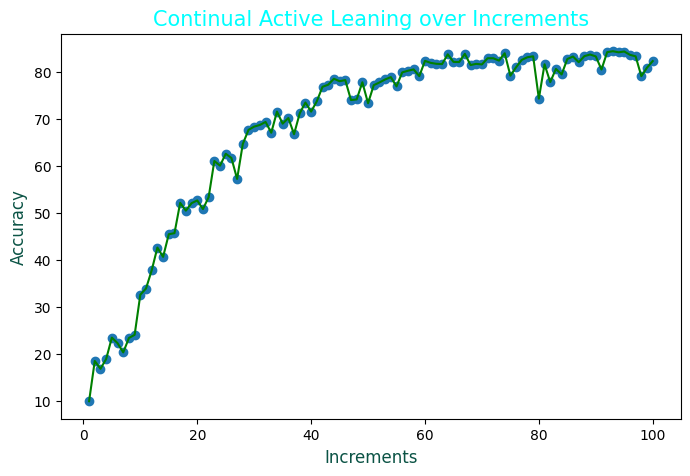

In [62]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(range(1,len(test_accuracies)+1),np.array(test_accuracies)*100,c='green')
plt.scatter(range(1,len(test_accuracies)+1),np.array(test_accuracies)*100)
plt.xlabel('Increments',fontsize =12,color='#0b5345')
plt.ylabel('Accuracy',fontsize =12,color='#0b5345')
# plt.title("VAE CAL  over Increments",fontsize =15,color='Cyan',)
plt.savefig('Resnet_34_VAE_CAL_15epoch_0.1KLD_0.8cs_1.png')
plt.show()

# Analysis

In [63]:
model.data_processing.selected_obj

['05_23',
 '06_12',
 '08_28',
 '11_47',
 '02_39',
 '01_26',
 '02_50',
 '05_28',
 '04_28',
 '01_33',
 '05_34',
 '11_40',
 '06_45',
 '01_32',
 '08_42',
 '11_35',
 '08_13',
 '04_32',
 '06_08',
 '11_24',
 '05_48',
 '05_29',
 '09_05',
 '01_01',
 '01_44',
 '04_31',
 '04_49',
 '02_09',
 '01_12',
 '04_29',
 '05_25',
 '04_26',
 '11_14',
 '11_19',
 '09_29',
 '11_03',
 '04_10',
 '04_50',
 '04_18',
 '09_27',
 '01_14',
 '08_18',
 '05_17',
 '06_17',
 '06_35',
 '05_40',
 '05_07',
 '05_02',
 '01_36',
 '08_48',
 '11_45',
 '05_50',
 '01_34',
 '11_33',
 '04_37',
 '05_19',
 '04_15',
 '06_22',
 '02_20',
 '04_12',
 '08_25',
 '06_02',
 '01_29',
 '05_15',
 '04_17',
 '06_39',
 '09_15',
 '04_21',
 '08_27',
 '06_28',
 '04_42',
 '08_33',
 '08_41',
 '09_12',
 '02_10',
 '08_20',
 '05_18',
 '02_11',
 '08_31',
 '09_06',
 '05_36',
 '04_06',
 '05_33',
 '08_49',
 '06_38',
 '11_11',
 '11_20',
 '06_29',
 '04_35',
 '11_28',
 '06_49',
 '04_36',
 '06_14',
 '09_28',
 '04_34',
 '05_30',
 '06_27',
 '06_07',
 '06_34',
 '11_26']

In [64]:
class Analysis:


    def data(self,data_process = model.data_processing):
        self.data_process = data_process
        d = {}
        objects_frequency = [0]*51
        for obj in self.data_process.selected_obj:
            sn = int(obj[0:2])
            on= int(obj[3:])
            objects_frequency[on] += 1 
            if sn not in d.keys():
                d[sn] = [on]
            else:
                d[sn].append(on)
        
        return d,objects_frequency
    
    def data_selected_obj(self):
        x,y = [],[]
        d , _ = self.data()

        for s in d.keys():
            for o in d[s]:
                xy = self.data_process.data_selector(train_features,train_paths,season=s,object=o)
                x.append(xy[0])
                y.append(xy[1])
        return np.concatenate(x,axis=0),np.concatenate(y,axis=0)
    
    def data_NotSelectedObject(self):
        not_selected_obj = []
        d , _ = self.data()
        for i in range(1,51):
            obj_present = False
            for key in d.keys():
                if i in d[key]:
                    obj_present = True
                    break
            if obj_present == False:
                not_selected_obj.append(i)
        return not_selected_obj



        

In [65]:
Analysis().data()

({5: [23, 28, 34, 48, 29, 25, 17, 40, 7, 2, 50, 19, 15, 18, 36, 33, 30],
  6: [12, 45, 8, 17, 35, 22, 2, 39, 28, 38, 29, 49, 14, 27, 7, 34],
  8: [28, 42, 13, 18, 48, 25, 27, 33, 41, 20, 31, 49],
  11: [47, 40, 35, 24, 14, 19, 3, 45, 33, 11, 20, 28, 26],
  2: [39, 50, 9, 20, 10, 11],
  1: [26, 33, 32, 1, 44, 12, 14, 36, 34, 29],
  4: [28,
   32,
   31,
   49,
   29,
   26,
   10,
   50,
   18,
   37,
   15,
   12,
   17,
   21,
   42,
   6,
   35,
   36,
   34],
  9: [5, 29, 27, 15, 12, 6, 28]},
 [0,
  1,
  2,
  1,
  0,
  1,
  2,
  2,
  1,
  1,
  2,
  2,
  4,
  1,
  3,
  3,
  0,
  3,
  3,
  2,
  3,
  1,
  1,
  1,
  1,
  2,
  3,
  3,
  6,
  5,
  1,
  2,
  2,
  4,
  4,
  3,
  3,
  1,
  1,
  2,
  2,
  1,
  2,
  0,
  1,
  2,
  0,
  1,
  2,
  3,
  3])

<BarContainer object of 51 artists>

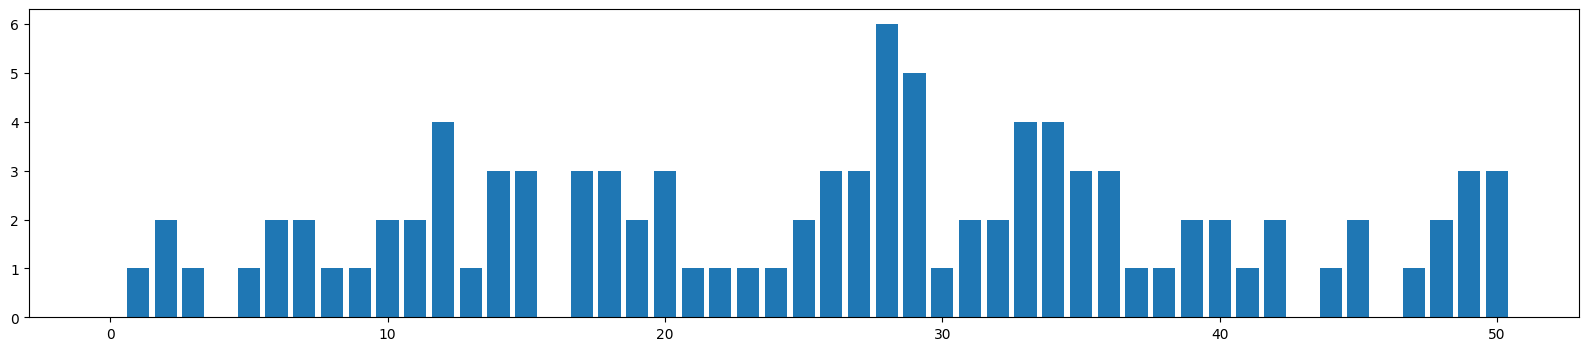

In [66]:
plt.figure(figsize=(20,4))
plt.bar(range(51),Analysis().data()[1])

In [67]:
np.sum(np.array(Analysis().data()[1]))

100

In [68]:
x,y = Analysis().data_selected_obj()
x.shape,y.shape

((29975, 512), (29975,))

In [69]:
Analysis().data_NotSelectedObject()

[4, 16, 43, 46]

In [70]:
custom_dataset1 = CustomDataset(x,y)
train_loader1 = torch.utils.data.DataLoader(custom_dataset1, batch_size=batch_size,shuffle = True)

classifier1 = Classifier(10)
classifier1.to(device)
criterion1 = torch.nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(classifier1.parameters(),lr=0.001,momentum = 0.9)
for epoch in range(1,101):
    with torch.enable_grad():
        correct_predictions = 0
        total_samples = 0
        running_loss = 0.0
        for batch in train_loader1:  # Iterate over batches of training data
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
            # Forward pass

            outputs = classifier1(inputs.float())

            # Compute loss
            loss = criterion1(outputs, labels.long())
            # Backpropagation and optimization

            optimizer1.zero_grad()
            loss.backward(retain_graph=True )
            optimizer1.step()

            total_samples += labels.size(0)
            running_loss += loss.item()/total_samples

            # Compute accuracy for the current batch
            _, predicted = torch.max(outputs, 1)  # Get the class with the highest probability
            correct_predictions += (predicted == labels).sum().item()

        # Calculate accuracy for the current epoch
        accuracy = correct_predictions / total_samples

        # Print accuracy for monitoring training progress
        print(f'Epoch [{epoch}] -loss {running_loss:.4f} - Accuracy: {accuracy * 100:.2f}% ')
        if accuracy >0.9999:
            break

    correct_predictions_test = 0
    with torch.no_grad():
        test_output = classifier1(test_x)
        _, test_predicted = torch.max(test_output, 1)
        correct_predictions_test += (test_predicted == test_y).sum().item()
        test_accuracy = correct_predictions_test/no_test_samples
        print(f'\nTest accuracy : {test_accuracy* 100:.2f}% ')

Epoch [1] -loss 0.7490 - Accuracy: 94.41% 

Test accuracy : 85.66% 
Epoch [2] -loss 0.0519 - Accuracy: 98.33% 

Test accuracy : 87.07% 
Epoch [3] -loss 0.0343 - Accuracy: 98.85% 

Test accuracy : 86.90% 
Epoch [4] -loss 0.0221 - Accuracy: 99.06% 

Test accuracy : 87.11% 
Epoch [5] -loss 0.0254 - Accuracy: 99.26% 

Test accuracy : 87.02% 
Epoch [6] -loss 0.0197 - Accuracy: 99.35% 

Test accuracy : 86.86% 
Epoch [7] -loss 0.0153 - Accuracy: 99.45% 

Test accuracy : 87.19% 
Epoch [8] -loss 0.0182 - Accuracy: 99.52% 

Test accuracy : 86.78% 
Epoch [9] -loss 0.0131 - Accuracy: 99.63% 

Test accuracy : 86.82% 
Epoch [10] -loss 0.0129 - Accuracy: 99.63% 

Test accuracy : 86.79% 
Epoch [11] -loss 0.0113 - Accuracy: 99.69% 

Test accuracy : 86.93% 
Epoch [12] -loss 0.0089 - Accuracy: 99.69% 

Test accuracy : 86.56% 
Epoch [13] -loss 0.0141 - Accuracy: 99.75% 

Test accuracy : 87.15% 
Epoch [14] -loss 0.0075 - Accuracy: 99.76% 

Test accuracy : 86.56% 
Epoch [15] -loss 0.0121 - Accuracy: 99.79% 